# BERT Classifier - easiest version

In [1]:
# setup - load packages
%pip install optuna
%pip install evaluate
import evaluate
import pandas as pd
from datasets import Dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer


seed = 13

# load data
preprocessed_data = pd.read_csv("/content/classifier_data_A_downsampled.csv")
#preprocessed_data = pd.read_csv("../data/classifier_data_A.csv")

In [2]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# quantized?!

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 109,085,958


In [3]:
party_to_id = {party: i for i, party in enumerate(sorted(preprocessed_data['label'].unique()))}
preprocessed_data['label'] = preprocessed_data['label'].map(party_to_id)


# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(preprocessed_data)

# Tokenize
def tokenize(batch):
    return tokenizer(batch['speech_text'], truncation=True, padding=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")  # required name
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset = dataset.train_test_split(test_size=0.3)  # 90% train, 10% val
train_dataset = dataset['train']
val_and_test_dataset = dataset['test']
val_and_test_dataset = val_and_test_dataset.train_test_split(test_size=0.5)  # 90% train, 10% val
val_dataset = val_and_test_dataset['train']
test_dataset = val_and_test_dataset['test']

Map:   0%|          | 0/21708 [00:00<?, ? examples/s]

In [10]:
# training arguments for hyperparameter tuning
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",  # don't save checkpoints during tuning
    logging_dir="./logs",
    disable_tqdm=True,  # speed up tuning
    report_to="none",   # optional: disable W&B or other logging
)

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 3),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }


accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



best_run = trainer.hyperparameter_search(
    direction="maximize",        # because we want to maximize accuracy
    hp_space=hp_space,
    n_trials=10,                 # how many combinations to try
    compute_objective=lambda metrics: metrics["eval_accuracy"],
    backend="optuna"
)

print("Best hyperparameters:")
print(best_run.hyperparameters)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.2 MB/s eta 0:00:00


/tmp/ipython-input-712449088.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-01 11:07:23,604] A new study created in memory with name: no-name-7a37b2e3-94c3-4da8-bb90-e08cf998feec
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_at

{'loss': 1.4975, 'grad_norm': 12.905914306640625, 'learning_rate': 2.7737501380550032e-05, 'epoch': 0.5263157894736842}
{'eval_loss': 1.0368621349334717, 'eval_accuracy': 0.5866093366093366, 'eval_runtime': 21.7222, 'eval_samples_per_second': 149.893, 'eval_steps_per_second': 18.737, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.1368, 'grad_norm': 12.154329299926758, 'learning_rate': 1.783832173010391e-05, 'epoch': 1.0526315789473684}
{'loss': 0.8311, 'grad_norm': 8.418688774108887, 'learning_rate': 7.93914207965779e-06, 'epoch': 1.5789473684210527}
{'eval_loss': 0.8845452070236206, 'eval_accuracy': 0.6517199017199017, 'eval_runtime': 21.7046, 'eval_samples_per_second': 150.014, 'eval_steps_per_second': 18.752, 'epoch': 2.0}
{'train_runtime': 633.3314, 'train_samples_per_second': 47.984, 'train_steps_per_second': 3.0, 'train_loss': 1.0712959209241366, 'epoch': 2.0}


[I 2025-08-01 11:17:58,544] Trial 0 finished with value: 0.6517199017199017 and parameters: {'learning_rate': 3.7616882671695263e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.1970938632742163}. Best is trial 0 with value: 0.6517199017199017.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.636, 'grad_norm': 18.654468536376953, 'learning_rate': 3.3654006833531035e-05, 'epoch': 0.2631578947368421}
{'loss': 1.3506, 'grad_norm': 10.49891471862793, 'learning_rate': 2.855645960033942e-05, 'epoch': 0.5263157894736842}
{'loss': 1.2283, 'grad_norm': 11.021450996398926, 'learning_rate': 2.3458912367147806e-05, 'epoch': 0.7894736842105263}
{'eval_loss': 1.0217441320419312, 'eval_accuracy': 0.5982800982800983, 'eval_runtime': 21.7612, 'eval_samples_per_second': 149.624, 'eval_steps_per_second': 18.703, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.0682, 'grad_norm': 19.82706642150879, 'learning_rate': 1.836136513395619e-05, 'epoch': 1.0526315789473684}
{'loss': 0.8706, 'grad_norm': 14.001827239990234, 'learning_rate': 1.326381790076458e-05, 'epoch': 1.3157894736842106}
{'loss': 0.8281, 'grad_norm': 8.601998329162598, 'learning_rate': 8.166270667572966e-06, 'epoch': 1.5789473684210527}
{'loss': 0.7671, 'grad_norm': 14.951750755310059, 'learning_rate': 3.068723434381351e-06, 'epoch': 1.8421052631578947}
{'eval_loss': 0.879437267780304, 'eval_accuracy': 0.6587837837837838, 'eval_runtime': 21.4897, 'eval_samples_per_second': 151.514, 'eval_steps_per_second': 18.939, 'epoch': 2.0}
{'train_runtime': 682.9471, 'train_samples_per_second': 44.498, 'train_steps_per_second': 5.564, 'train_loss': 1.0787978844893606, 'epoch': 2.0}


[I 2025-08-01 11:29:23,135] Trial 1 finished with value: 0.6587837837837838 and parameters: {'learning_rate': 3.8741358972256265e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.11264083429401135}. Best is trial 1 with value: 0.6587837837837838.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.4555, 'grad_norm': 10.584847450256348, 'learning_rate': 2.8641616327097518e-05, 'epoch': 0.5263157894736842}
{'eval_loss': 1.045796275138855, 'eval_accuracy': 0.5912162162162162, 'eval_runtime': 21.4017, 'eval_samples_per_second': 152.138, 'eval_steps_per_second': 19.017, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.1006, 'grad_norm': 10.631120681762695, 'learning_rate': 1.8419768958397477e-05, 'epoch': 1.0526315789473684}
{'loss': 0.7992, 'grad_norm': 14.675676345825195, 'learning_rate': 8.197921589697435e-06, 'epoch': 1.5789473684210527}
{'eval_loss': 0.8668789267539978, 'eval_accuracy': 0.6621621621621622, 'eval_runtime': 21.4108, 'eval_samples_per_second': 152.073, 'eval_steps_per_second': 19.009, 'epoch': 2.0}
{'train_runtime': 630.751, 'train_samples_per_second': 48.181, 'train_steps_per_second': 3.012, 'train_loss': 1.0356442100123355, 'epoch': 2.0}


[I 2025-08-01 11:39:55,476] Trial 2 finished with value: 0.6621621621621622 and parameters: {'learning_rate': 3.884302000106016e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.07106900408892262}. Best is trial 2 with value: 0.6621621621621622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.4628, 'grad_norm': 13.731610298156738, 'learning_rate': 2.127207340774725e-05, 'epoch': 0.5263157894736842}
{'eval_loss': 1.0483828783035278, 'eval_accuracy': 0.5841523341523341, 'eval_runtime': 21.6806, 'eval_samples_per_second': 150.18, 'eval_steps_per_second': 18.773, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.1134, 'grad_norm': 14.809700012207031, 'learning_rate': 1.3680327009550516e-05, 'epoch': 1.0526315789473684}
{'loss': 0.8361, 'grad_norm': 12.583454132080078, 'learning_rate': 6.088580611353782e-06, 'epoch': 1.5789473684210527}
{'eval_loss': 0.899567186832428, 'eval_accuracy': 0.6468058968058968, 'eval_runtime': 21.3386, 'eval_samples_per_second': 152.588, 'eval_steps_per_second': 19.073, 'epoch': 2.0}
{'train_runtime': 631.296, 'train_samples_per_second': 48.139, 'train_steps_per_second': 3.01, 'train_loss': 1.0613993915758635, 'epoch': 2.0}


[I 2025-08-01 11:50:28,358] Trial 3 finished with value: 0.6468058968058968 and parameters: {'learning_rate': 2.884863631314759e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.2527508590495112}. Best is trial 2 with value: 0.6621621621621622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 1.2100039720535278, 'eval_accuracy': 0.5122850122850123, 'eval_runtime': 21.2958, 'eval_samples_per_second': 152.894, 'eval_steps_per_second': 19.112, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.3627, 'grad_norm': 18.245683670043945, 'learning_rate': 1.181282912331477e-05, 'epoch': 1.0526315789473684}
{'eval_loss': 1.059301733970642, 'eval_accuracy': 0.5881449631449631, 'eval_runtime': 21.3237, 'eval_samples_per_second': 152.694, 'eval_steps_per_second': 19.087, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.9631, 'grad_norm': 6.841609477996826, 'learning_rate': 5.4344116701210505e-06, 'epoch': 2.1052631578947367}
{'eval_loss': 0.9839590191841125, 'eval_accuracy': 0.6231572481572482, 'eval_runtime': 21.7176, 'eval_samples_per_second': 149.924, 'eval_steps_per_second': 18.741, 'epoch': 3.0}
{'train_runtime': 900.5382, 'train_samples_per_second': 50.62, 'train_steps_per_second': 1.582, 'train_loss': 1.0418718947025767, 'epoch': 3.0}


[I 2025-08-01 12:05:30,534] Trial 4 finished with value: 0.6231572481572482 and parameters: {'learning_rate': 1.8178489741602105e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.13291597377928463}. Best is trial 2 with value: 0.6621621621621622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.5799, 'grad_norm': 12.87143611907959, 'learning_rate': 1.3015559889501643e-05, 'epoch': 0.2631578947368421}
{'loss': 1.3328, 'grad_norm': 14.471585273742676, 'learning_rate': 1.104410277203699e-05, 'epoch': 0.5263157894736842}
{'loss': 1.2146, 'grad_norm': 6.6233649253845215, 'learning_rate': 9.072645654572337e-06, 'epoch': 0.7894736842105263}


[I 2025-08-01 12:11:12,863] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.072949767112732, 'eval_accuracy': 0.5675675675675675, 'eval_runtime': 21.7557, 'eval_samples_per_second': 149.662, 'eval_steps_per_second': 18.708, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 1.0965726375579834, 'eval_accuracy': 0.5586609336609336, 'eval_runtime': 21.7444, 'eval_samples_per_second': 149.74, 'eval_steps_per_second': 18.717, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.326, 'grad_norm': 16.464479446411133, 'learning_rate': 1.2324908620535036e-05, 'epoch': 1.0526315789473684}
{'eval_loss': 0.9629242420196533, 'eval_accuracy': 0.6197788697788698, 'eval_runtime': 21.7342, 'eval_samples_per_second': 149.81, 'eval_steps_per_second': 18.726, 'epoch': 2.0}
{'train_runtime': 601.4788, 'train_samples_per_second': 50.525, 'train_steps_per_second': 1.579, 'train_loss': 1.1259513132195724, 'epoch': 2.0}


[I 2025-08-01 12:21:15,976] Trial 6 finished with value: 0.6197788697788698 and parameters: {'learning_rate': 2.5961559178510608e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.006466143738172991}. Best is trial 2 with value: 0.6621621621621622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 1.0323988199234009, 'eval_accuracy': 0.5896805896805897, 'eval_runtime': 21.708, 'eval_samples_per_second': 149.991, 'eval_steps_per_second': 18.749, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.3137, 'grad_norm': 14.093592643737793, 'learning_rate': 1.7868152674163966e-05, 'epoch': 1.0526315789473684}
{'eval_loss': 0.9182451367378235, 'eval_accuracy': 0.6378992628992629, 'eval_runtime': 21.7117, 'eval_samples_per_second': 149.965, 'eval_steps_per_second': 18.746, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.8559, 'grad_norm': 5.864048480987549, 'learning_rate': 8.220122072563552e-06, 'epoch': 2.1052631578947367}
{'eval_loss': 0.8997822999954224, 'eval_accuracy': 0.6569410319410319, 'eval_runtime': 21.3714, 'eval_samples_per_second': 152.353, 'eval_steps_per_second': 19.044, 'epoch': 3.0}
{'train_runtime': 901.3676, 'train_samples_per_second': 50.573, 'train_steps_per_second': 1.581, 'train_loss': 0.942578981633772, 'epoch': 3.0}


[I 2025-08-01 12:36:18,948] Trial 7 finished with value: 0.6569410319410319 and parameters: {'learning_rate': 2.749688721456118e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.08977404947591267}. Best is trial 2 with value: 0.6621621621621622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.5874, 'grad_norm': 10.626958847045898, 'learning_rate': 9.020988284948583e-06, 'epoch': 0.2631578947368421}
{'loss': 1.3563, 'grad_norm': 17.292417526245117, 'learning_rate': 7.654585939455006e-06, 'epoch': 0.5263157894736842}
{'loss': 1.2664, 'grad_norm': 10.380831718444824, 'learning_rate': 6.288183593961432e-06, 'epoch': 0.7894736842105263}


[I 2025-08-01 12:41:59,145] Trial 8 pruned. 


{'eval_loss': 1.1670197248458862, 'eval_accuracy': 0.5319410319410319, 'eval_runtime': 21.3745, 'eval_samples_per_second': 152.331, 'eval_steps_per_second': 19.041, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 1.57, 'grad_norm': 15.6035795211792, 'learning_rate': 2.2736173383113846e-05, 'epoch': 0.2631578947368421}
{'loss': 1.3, 'grad_norm': 12.376632690429688, 'learning_rate': 2.0550423202080023e-05, 'epoch': 0.5263157894736842}
{'loss': 1.1619, 'grad_norm': 15.062520980834961, 'learning_rate': 1.8364673021046197e-05, 'epoch': 0.7894736842105263}


[I 2025-08-01 12:47:39,569] Trial 9 pruned. 


{'eval_loss': 1.028995156288147, 'eval_accuracy': 0.5952088452088452, 'eval_runtime': 21.3874, 'eval_samples_per_second': 152.239, 'eval_steps_per_second': 19.03, 'epoch': 1.0}
Best hyperparameters:
{'learning_rate': 3.884302000106016e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.07106900408892262}


In [12]:
# Create new training args with best values
best_args = training_args

best_args = TrainingArguments(
    output_dir="./best_results",
    learning_rate=best_run.hyperparameters["learning_rate"],
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    num_train_epochs=best_run.hyperparameters["num_train_epochs"],
    weight_decay=best_run.hyperparameters["weight_decay"],
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./best_logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


# New trainer with updated args
trainer = Trainer(
    model=model,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Retrain with best hyperparameters
trainer.train()


/tmp/ipython-input-3942944365.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.439300,1.019091,0.601044
2,0.789300,0.892500,0.655713


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=1900, training_loss=1.0238540970651726, metrics={'train_runtime': 635.6113, 'train_samples_per_second': 47.812, 'train_steps_per_second': 2.989, 'total_flos': 7996232141844480.0, 'train_loss': 1.0238540970651726, 'epoch': 2.0})

In [13]:
# validaten
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.8924999833106995,
 'eval_accuracy': 0.6557125307125307,
 'eval_runtime': 22.0235,
 'eval_samples_per_second': 147.842,
 'eval_steps_per_second': 18.48,
 'epoch': 2.0}

In [14]:
def predicting_probs_to_preds(model, text, tokenizer=tokenizer, max_length=max_length):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

    # Move inputs to the same device as the model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
    return pred, probs.squeeze().tolist()  # return list of class probabilities


In [15]:
# collect evaluation data
def evaluate_model(model, data):
    prediction_list = []
    probability_list = []
    true_label_list = []

    for i, row in data.iterrows():
        speech = row["speech_text"]
        pred, probs = predicting_probs_to_preds(model, speech)
        true_label = row["labels"]
        prediction_list.append(pred)
        probability_list.append(probs)
        true_label_list.append(true_label)

        if (i+1) % 100 == 0:
            print(f"Processed samples {i+1} of {len(data)} samples.")

    return prediction_list, probability_list, true_label_list


# define function to display eval metrics
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



In [16]:
# evaluate model performance

val_df = val_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Evaluate on validation set
val_preds, val_probs, val_labels = evaluate_model(model, val_df)
# Evaluate on test set
test_preds, test_probs, test_labels = evaluate_model(model, test_df)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processed samples 100 of 3256 samples.
Processed samples 200 of 3256 samples.
Processed samples 300 of 3256 samples.
Processed samples 400 of 3256 samples.
Processed samples 500 of 3256 samples.
Processed samples 600 of 3256 samples.
Processed samples 700 of 3256 samples.
Processed samples 800 of 3256 samples.
Processed samples 900 of 3256 samples.
Processed samples 1000 of 3256 samples.
Processed samples 1100 of 3256 samples.
Processed samples 1200 of 3256 samples.
Processed samples 1300 of 3256 samples.
Processed samples 1400 of 3256 samples.
Processed samples 1500 of 3256 samples.
Processed samples 1600 of 3256 samples.
Processed samples 1700 of 3256 samples.
Processed samples 1800 of 3256 samples.
Processed samples 1900 of 3256 samples.
Processed samples 2000 of 3256 samples.
Processed samples 2100 of 3256 samples.
Processed samples 2200 of 3256 samples.
Processed samples 2300 of 3256 samples.
Processed samples 2400 of 3256 samples.
Processed samples 2500 of 3256 samples.
Processed

In [17]:
id_to_party = {v: k for k, v in party_to_id.items()}

def create_eval_df(preds, probs, labels, df, id_to_party):
    def decode(x):
        return id_to_party[x] if isinstance(x, int) else x

    return pd.DataFrame({
        "speech_text": df["speech_text"],
        "true_label": [decode(i) for i in labels],
        "predicted_label": [decode(i) for i in preds],
        "probabilities": probs
    })

In [18]:
val_eval_df = create_eval_df(val_preds, val_probs, val_labels, val_df, id_to_party)
test_eval_df = create_eval_df(test_preds, test_probs, test_labels, test_df, id_to_party)
val_eval_df.to_csv("/content/classifier_val_results.csv", index=False)
test_eval_df.to_csv("/content/classifier_test_results.csv", index=False)

Model: bert-base-german-cased
  Accuracy: 0.6557125307125307
  Balanced Accuracy: 0.6542162922979329
  Precision: 0.6563828195869662
  Recall: 0.6542162922979329
  F1-score: 0.6534357138984596
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.93      0.87      0.90       584
     CDU/CSU       0.62      0.59      0.61       564
         FDP       0.62      0.55      0.58       509
       GRÜNE       0.56      0.53      0.54       548
       LINKE       0.69      0.81      0.74       508
         SPD       0.51      0.57      0.54       543

    accuracy                           0.66      3256
   macro avg       0.66      0.65      0.65      3256
weighted avg       0.66      0.66      0.66      3256



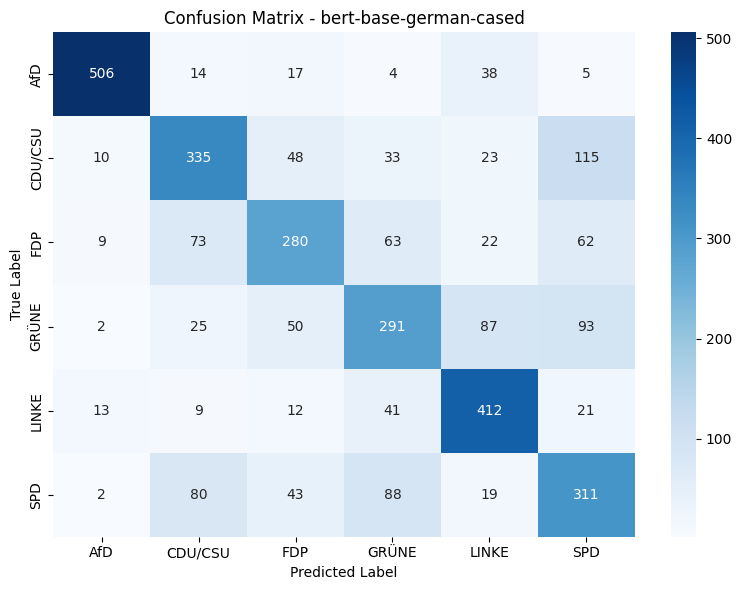

Model: bert-base-german-cased
  Accuracy: 0.6545901136014738
  Balanced Accuracy: 0.6560691387745775
  Precision: 0.6589944178129961
  Recall: 0.6560691387745775
  F1-score: 0.65517044038219
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.94      0.86      0.90       530
     CDU/CSU       0.58      0.58      0.58       534
         FDP       0.64      0.53      0.58       573
       GRÜNE       0.55      0.54      0.55       515
       LINKE       0.72      0.85      0.78       541
         SPD       0.53      0.58      0.55       564

    accuracy                           0.65      3257
   macro avg       0.66      0.66      0.66      3257
weighted avg       0.66      0.65      0.65      3257



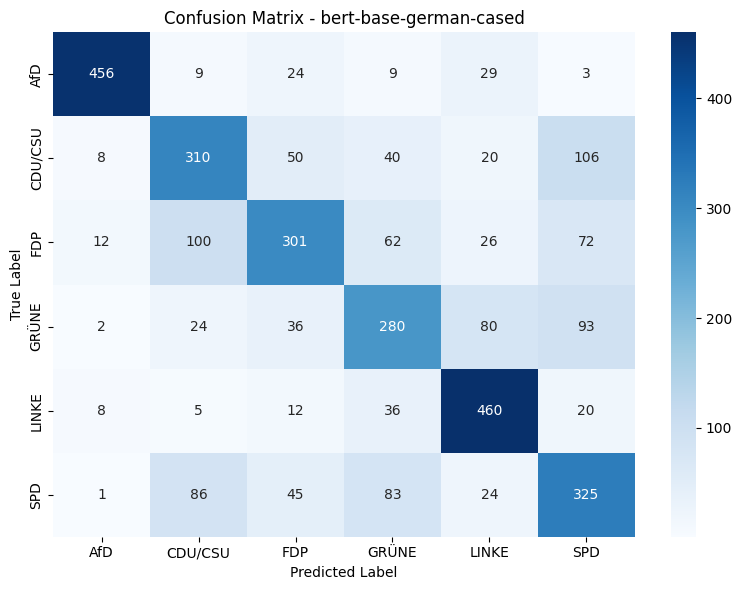

{'bert-base-german-cased': {'acc': 0.6545901136014738,
  'bal_acc': np.float64(0.6560691387745775),
  'precision': 0.6589944178129961,
  'recall': 0.6560691387745775,
  'f1': 0.65517044038219}}

In [19]:
# evaluate
# On validation set
get_metrics(val_eval_df["true_label"], val_eval_df["predicted_label"])

# On test set
get_metrics(test_eval_df["true_label"], test_eval_df["predicted_label"])

In [20]:
# save fine-tuned model
model.save_pretrained("vanilla-bert-party-classifier/")
tokenizer.save_pretrained("vanilla-bert-party-classifier/")

('vanilla-bert-party-classifier/tokenizer_config.json',
 'vanilla-bert-party-classifier/special_tokens_map.json',
 'vanilla-bert-party-classifier/vocab.txt',
 'vanilla-bert-party-classifier/added_tokens.json',
 'vanilla-bert-party-classifier/tokenizer.json')